In [1]:
import glob

import pymaster as nmt

import healpy

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

PI = np.pi

In [2]:
Z_CUTS = [(0.1, 0.3),
          (0.3, 0.5),
          (0.5, 0.7),
          (0.7, 0.9),
          (0.9, 1.2),
         ]

BIN_OPERATOR = np.loadtxt("../data/xcorr/bin_operator_log_n_bin_13_ell_51-2952.txt")
BIN_OPERATOR_SQUARED = np.loadtxt("../data/xcorr/bin_operator_log_n_bin_13_ell_51-2952_squared_weights.txt")

n_ell_bin, n_ell = BIN_OPERATOR.shape

In [3]:
NMT_WORKSPACE_PATH = "/disk09/ttroester/project_triad/namaster_workspaces/"

In [4]:
# All KiDS
# KiDS1000_stats = [{"n_eff": 0.62, "sigma_e" : 0.27},
#                   {"n_eff": 1.18, "sigma_e" : 0.26},
#                   {"n_eff": 1.85, "sigma_e" : 0.27},
#                   {"n_eff": 1.26, "sigma_e" : 0.25},
#                   {"n_eff": 1.31, "sigma_e" : 0.27},]

# KiDS-N
KiDS1000_stats = [{"n_eff": 0.62, "sigma_e" : 0.27},
                  {"n_eff": 1.20, "sigma_e" : 0.26},
                  {"n_eff": 1.82, "sigma_e" : 0.27},
                  {"n_eff": 1.19, "sigma_e" : 0.25},
                  {"n_eff": 1.17, "sigma_e" : 0.27},]

ell = np.arange(3*2048)

Cl_gy_TE = 0*ell
Cl_gy_TB = 0*ell

Cl_gg_EE = []
for bin_idx in [0, 1, 2, 3, 4]:
    Cl_gg_EE += [np.ones_like(ell)*KiDS1000_stats[bin_idx]["sigma_e"]**2/(KiDS1000_stats[bin_idx]["n_eff"]*60**2/(1/180*PI)**2)]

Cl_gg_EB = 0*Cl_gg_EE[0]
Cl_gg_BB = 0*Cl_gg_EE[0]

# Planck milca half-difference x random shear

In [5]:
random_shear_data = np.load("../../project-triad-obsolete/results/measurements/shear_KiDS1000_y/shear_KiDS1000_y_random_shear.npz")

ell = np.arange(BIN_OPERATOR.shape[1])

y_map = "milca_half_difference"
d = []
for z_cut in Z_CUTS:
    tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}"
    binned = np.einsum("ij,kjl->lik", BIN_OPERATOR, random_shear_data[tag])
    d.append(binned)
    
d = np.concatenate(d, axis=1)
cov_random_shear = np.cov(d[0])

In [55]:
ell_Planck, Cl_milca_half_difference_yy = np.loadtxt("../../project-triad-obsolete/results/measurements/y_y/milca-half-difference-ellmax_4000/spice.cl", unpack=True)

Cl_yy_TT = np.concatenate((Cl_milca_half_difference_yy, np.zeros(3*2048-Cl_milca_half_difference_yy.size)))



In [13]:
nmt_cov_workspace = nmt.NmtCovarianceWorkspace()
nmt_cov_workspace.read_from("/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_cov_workspace_foreground_shear_4_foreground_shear_4.fits")

nmt_workspace_y_shear_A = nmt.NmtWorkspace()
nmt_workspace_y_shear_A.read_from("/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_workspace_foreground_shear_4.fits")
nmt_workspace_y_shear_B = nmt.NmtWorkspace()
nmt_workspace_y_shear_B.read_from("/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_workspace_foreground_shear_4.fits")

In [56]:
cov_gaussian_TE_TE = []

for bin_idx in [0, 1, 2, 3, 4]:
    nmt_workspace_y_shear_A = nmt.NmtWorkspace()
    nmt_workspace_y_shear_A.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_workspace_foreground_shear_{bin_idx}.fits")

    nmt_workspace_y_shear_B = nmt.NmtWorkspace()
    nmt_workspace_y_shear_B.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_workspace_foreground_shear_{bin_idx}.fits")

    nmt_cov_workspace = nmt.NmtCovarianceWorkspace()
    nmt_cov_workspace.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_cov_workspace_foreground_shear_{bin_idx}_foreground_shear_{bin_idx}.fits")

    cov_gaussian = nmt.covariance.gaussian_covariance(nmt_cov_workspace, 
                                                    spin_a1=0, spin_a2=2,
                                                    spin_b1=0, spin_b2=2,
                                                    cla1b1=[Cl_yy_TT],
                                                    cla1b2=[Cl_gy_TE, Cl_gy_TB],
                                                    cla2b1=[Cl_gy_TE, Cl_gy_TB],
                                                    cla2b2=[Cl_gg_EE[bin_idx], Cl_gg_EB, Cl_gg_EB, Cl_gg_BB],
                                                    wa=nmt_workspace_y_shear_A,
                                                    wb=nmt_workspace_y_shear_B).reshape([n_ell_bin, 2,
                                                                                         n_ell_bin, 2])
    cov_gaussian_TE_TE += [cov_gaussian[:, 0, :, 0]]

In [76]:
cov_gaussian_TE_TE_naive = []

ell = np.arange(Cl_yy_TT.size)

A_eff = 636.8005428
A_eff = 500.0
fsky_eff = A_eff/(4*PI*(180/PI)**2)

for bin_idx in [0, 1, 2, 3, 4]:
    cov = 1/(fsky_eff*(2*ell+1))*(Cl_yy_TT*Cl_gg_EE[bin_idx])
    
    cov_gaussian_TE_TE_naive += [BIN_OPERATOR_SQUARED @ cov[:n_ell]]

Text(0.5, 0.98, 'Noise-only covariance')

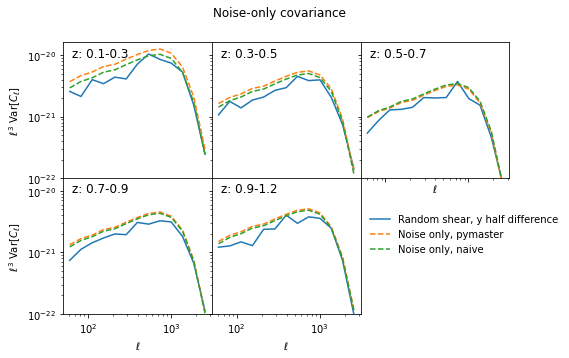

In [77]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

for i, z_cut in enumerate(Z_CUTS):
    ell_eff = BIN_OPERATOR @ np.arange(n_ell)
    u = ell_eff**3
    cov = cov_random_shear
    var = np.diag(cov)[n_ell_bin*i:n_ell_bin*(i+1)]

    ax.flatten()[i].loglog(ell_eff, u*var, ls="-", label=f"Random shear, y half difference")

    var = np.diag(cov_gaussian_TE_TE[i])
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"Noise only, pymaster")

    var = cov_gaussian_TE_TE_naive[i]
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"Noise only, naive")
    
    
    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)

[p[0].set_ylabel(r"$\ell^3\ {\rm Var}[C_\ell]$") for p in ax]
ax.flatten()[-1].axis("off")
ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

ax[0,0].set_ylim(bottom=1e-22)

fig.suptitle("Noise-only covariance")

# ACT BN x random shear

In [5]:

random_shear_data_TE = []
random_shear_data_TB = []

for filename in glob.glob("../results/measurements/shear_KiDS1000_random_shear_y_ACT_BN_namaster/run_*/Cl_decoupled.txt"):
    d_TE = np.concatenate(np.loadtxt(filename, unpack=True, usecols=[1, 3, 5, 7, 9]))
    d_TB = np.concatenate(np.loadtxt(filename, unpack=True, usecols=[2, 4, 6, 8, 10]))
    random_shear_data_TE.append(d_TE)
    random_shear_data_TB.append(d_TB)

cov_random_shear_TE = np.cov(np.array(random_shear_data_TE).T, ddof=1)
cov_random_shear_TB = np.cov(np.array(random_shear_data_TB).T, ddof=1)
cov_random_shear_combined = np.cov(np.array(random_shear_data_TE+random_shear_data_TB).T, ddof=1)

In [2]:
ell_ACT_coupled, Cl_ACT_BN_yy_coupled = np.loadtxt("../results/measurements/y_y_ACT_BN_namaster/Cl_TT_coupled.txt", unpack=True)
ell_ACT_decoupled, Cl_ACT_BN_yy_decoupled = np.loadtxt("../results/measurements/y_y_ACT_BN_namaster/Cl_TT_decoupled.txt", unpack=True)

nmt_bins = nmt.NmtBin.from_nside_linear(
                        nside=2048,
                        nlb=10)
Cl_ACT_BN_yy = nmt_bins.unbin_cell(Cl_ACT_BN_yy_decoupled)

Cl_yy_TT = np.concatenate((Cl_ACT_BN_yy, np.zeros(3*2048-Cl_ACT_BN_yy.size)))

np.savetxt("../results/measurements/y_y_ACT_BN_namaster/Cl_TT_decoupled_unbinned.txt",
           np.vstack((np.arange(Cl_yy_TT.size), Cl_yy_TT)).T)


In [7]:
cov_gaussian_TE_TE = []
cov_gaussian_TB_TB = []

for bin_idx in [0, 1, 2, 3, 4]:
    nmt_workspace_y_shear_A = nmt.NmtWorkspace()
    nmt_workspace_y_shear_A.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_ACT_BN_namaster/pymaster_workspace_foreground_shear_{bin_idx}.fits")

    nmt_workspace_y_shear_B = nmt.NmtWorkspace()
    nmt_workspace_y_shear_B.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_ACT_BN_namaster/pymaster_workspace_foreground_shear_{bin_idx}.fits")

    nmt_cov_workspace = nmt.NmtCovarianceWorkspace()
    nmt_cov_workspace.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_ACT_BN_namaster/pymaster_cov_workspace_foreground_shear_{bin_idx}_foreground_shear_{bin_idx}.fits")

    cov_gaussian = nmt.covariance.gaussian_covariance(nmt_cov_workspace, 
                                                    spin_a1=0, spin_a2=2,
                                                    spin_b1=0, spin_b2=2,
                                                    cla1b1=[Cl_yy_TT],
                                                    cla1b2=[Cl_gy_TE, Cl_gy_TB],
                                                    cla2b1=[Cl_gy_TE, Cl_gy_TB],
                                                    cla2b2=[Cl_gg_EE[bin_idx], Cl_gg_EB, Cl_gg_EB, Cl_gg_EE[bin_idx]],
                                                    wa=nmt_workspace_y_shear_A,
                                                    wb=nmt_workspace_y_shear_B).reshape([n_ell_bin, 2,
                                                                                         n_ell_bin, 2])
    cov_gaussian_TE_TE += [cov_gaussian[:, 0, :, 0]]
    cov_gaussian_TB_TB += [cov_gaussian[:, 1, :, 1]]

In [8]:
y_mask = healpy.read_map("../data/y_maps/ACT/BN_mask.fits", verbose=False)
y_mask[y_mask == healpy.UNSEEN] = 0

A_ACT_BN = y_mask.sum()*healpy.nside2pixarea(2048, degrees=True)

A_KiDS = {}
A_ACT_BN_KiDS = {}

for z_cut in Z_CUTS + [(0.1, 1.2)]:
    shear_mask = healpy.read_map(f"../data/shear_maps_KiDS1000_cel_N/z{z_cut[0]}-{z_cut[1]}/doublet_mask.fits", verbose=False)
    shear_mask[shear_mask == healpy.UNSEEN] = 0

    shear_weight = healpy.read_map(f"../data/shear_maps_KiDS1000_cel_N/z{z_cut[0]}-{z_cut[1]}/doublet_weight.fits", verbose=False)
    shear_weight[shear_weight == healpy.UNSEEN] = 0

    shear_weight *= shear_mask.sum()/shear_weight[shear_weight > 0].sum()

    A_KiDS[z_cut] = shear_weight.sum()*healpy.nside2pixarea(2048, degrees=True)
    A_ACT_BN_KiDS[z_cut] = (shear_weight*y_mask).sum()*healpy.nside2pixarea(2048, degrees=True)


/home/ttroester/Codes/miniconda/envs/kcap_env_re/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [9]:
A_ACT_BN, A_KiDS, A_ACT_BN_KiDS

(1717.1592809081303,
 {(0.1, 0.3): 325.1484233627889,
  (0.3, 0.5): 390.57890353584315,
  (0.5, 0.7): 415.7954155363968,
  (0.7, 0.9): 400.3889676369491,
  (0.9, 1.2): 401.5093918683981,
  (0.1, 1.2): 431.3723449575278},
 {(0.1, 0.3): 254.03078387008193,
  (0.3, 0.5): 302.304002815419,
  (0.5, 0.7): 323.0380847130546,
  (0.7, 0.9): 316.22574061991025,
  (0.9, 1.2): 315.3931489512578,
  (0.1, 1.2): 336.7292221497724})

In [10]:
cov_gaussian_TE_TE_naive = []
cov_gaussian_TE_TE_naive_fixed_area = []

ell = np.arange(Cl_yy_TT.size)

for bin_idx in [0, 1, 2, 3, 4]:
    A_eff = list(A_ACT_BN_KiDS.values())[bin_idx]
    fsky_eff = A_eff/(4*PI*(180/PI)**2)
    cov = 1/(fsky_eff*(2*ell+1))*(Cl_yy_TT*Cl_gg_EE[bin_idx])
    cov_gaussian_TE_TE_naive += [BIN_OPERATOR_SQUARED @ cov[:n_ell]]

    A_eff = 291
    fsky_eff = A_eff/(4*PI*(180/PI)**2)
    cov = 1/(fsky_eff*(2*ell+1))*(Cl_yy_TT*Cl_gg_EE[bin_idx])
    cov_gaussian_TE_TE_naive_fixed_area += [BIN_OPERATOR_SQUARED @ cov[:n_ell]]

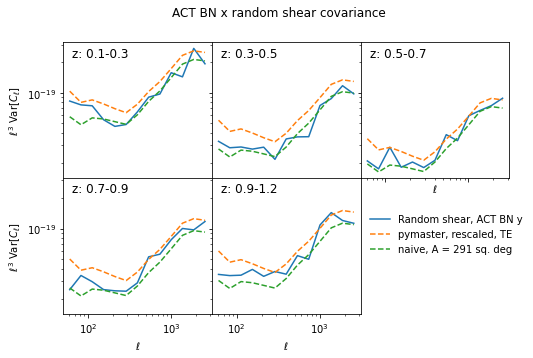

In [11]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

for i, z_cut in enumerate(Z_CUTS):
    ell_eff = BIN_OPERATOR @ np.arange(n_ell)
    u = ell_eff**3
    
    cov = cov_random_shear_TE
    var = np.diag(cov)[n_ell_bin*i:n_ell_bin*(i+1)]
    ax.flatten()[i].loglog(ell_eff, u*var, ls="-", label=f"Random shear, ACT BN y")

    # cov = cov_random_shear_TB
    # var = np.diag(cov)[n_ell_bin*i:n_ell_bin*(i+1)]
    # ax.flatten()[i].loglog(ell_eff, u*var, ls="-", label=f"Random shear, ACT BN y, TB")

    # var = np.diag(cov_gaussian_TE_TE[i])
    # ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"pymaster, TE")

    var = np.diag(cov_gaussian_TE_TE[i])
    var = var * A_ACT_BN_KiDS[z_cut]/A_ACT_BN_KiDS[(0.1, 1.2)]
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"pymaster, rescaled, TE")

    # var = np.diag(cov_gaussian_TB_TB[i])
    # ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"pymaster, TB")

    # var = cov_gaussian_TE_TE_naive[i]
    # ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"naive")

    var = cov_gaussian_TE_TE_naive_fixed_area[i]
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"naive, A = 291 sq. deg")
    
    
    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)

[p[0].set_ylabel(r"$\ell^3\ {\rm Var}[C_\ell]$") for p in ax]
ax.flatten()[-1].axis("off")
ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

# ax[0,0].set_ylim(bottom=1e-22)

fig.suptitle("ACT BN x random shear covariance")
fig.savefig("plots/ACT_BN_noise_cov.png", dpi=300)

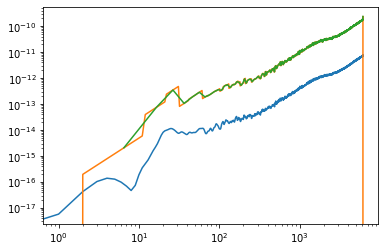

In [11]:
u = ell_ACT_coupled**2/(2*PI)
plt.loglog(ell_ACT_coupled, u*Cl_ACT_BN_yy_coupled)
plt.loglog(ell_ACT_coupled, u*Cl_ACT_BN_yy)

u = ell_ACT_decoupled**2/(2*PI)
plt.loglog(ell_ACT_decoupled, u*Cl_ACT_BN_yy_decoupled)

In [33]:
import pylenspice.pylenspice

catalog = "/disk09/KIDS/KIDSCOLLAB_V1.0.0/WL_gold_cat_release_DR4.1/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits"
catalog_hdu = 1

KiDS_column_names = {"x" : "ALPHA_J2000",
                            "y" : "DELTA_J2000",
                            "e1": "e1",
                            "e2": "e2",
                            "w" : "weight",
                            "z" : "Z_B"}

KiDS_selection = [("weight", "gt", 0.0),]

# if args.only_north:
KiDS_selection += [("DELTA_J2000", "gt", -20.0),]

Z_CUTS = [(0.1, 0.3),
            (0.3, 0.5),
            (0.5, 0.7),
            (0.7, 0.9),
            (0.9, 1.2),
            ]

sum_w = {}
sum_w_sq = {}
sum_w_sq_e1_sq = {}
sum_w_sq_e2_sq = {}

sigma_e_sq = {}

for z_cut in Z_CUTS:
    ra, dec, e1, e2, w, m = pylenspice.pylenspice.prepare_catalog(catalog_filename=catalog, 
                                                column_names=KiDS_column_names, 
                                                c_correction="data", 
                                                m_correction=None, 
                                                z_min=z_cut[0], z_max=z_cut[1], 
                                                selections=KiDS_selection, 
                                                hdu_idx=catalog_hdu,
                                                verbose=True)

    sum_w[z_cut] = np.sum(w)
    sum_w_sq[z_cut] = np.sum(w**2)

    sum_w_sq_e1_sq[z_cut] = np.sum(w**2 * e1**2)
    sum_w_sq_e2_sq[z_cut] = np.sum(w**2 * e2**2)

Applying gt 0.0 on weight.
Applying gt -20.0 on DELTA_J2000.
Applying z cut: 0.1-0.3.
Applying c correction calculated from the data.
Applying gt 0.0 on weight.
Applying gt -20.0 on DELTA_J2000.
Applying z cut: 0.3-0.5.
Applying c correction calculated from the data.
Applying gt 0.0 on weight.
Applying gt -20.0 on DELTA_J2000.
Applying z cut: 0.5-0.7.
Applying c correction calculated from the data.
Applying gt 0.0 on weight.
Applying gt -20.0 on DELTA_J2000.
Applying z cut: 0.7-0.9.
Applying c correction calculated from the data.
Applying gt 0.0 on weight.
Applying gt -20.0 on DELTA_J2000.
Applying z cut: 0.9-1.2.
Applying c correction calculated from the data.


In [37]:
# 0.26962160 0.25788498 0.27258682 0.25393726 0.27027384

area_file = "/home/cech/KiDSLenS/THELI_catalogues/KIDS_conf/EFFECTIVE_AREA_NEFF/K1000_N_eff_area.txt"
A = np.loadtxt(area_file, converters={0: lambda s: 0.0})[:,-1]
for z_cut in Z_CUTS:
    sigma_e = np.sqrt(0.5*(sum_w_sq_e1_sq[z_cut] + sum_w_sq_e2_sq[z_cut])/sum_w_sq[z_cut])
    n_eff = sum_w[z_cut]**2/sum_w_sq[z_cut]/np.sum(A)

    print(f"sigma_e: {sigma_e:.2f}, n_eff: {n_eff:.2f}")


sigma_e: 0.27, n_eff: 0.62
sigma_e: 0.26, n_eff: 1.20
sigma_e: 0.27, n_eff: 1.82
sigma_e: 0.25, n_eff: 1.19
sigma_e: 0.27, n_eff: 1.17


In [48]:
np.sum(A)/60**2/431.3723*336

291.8789744000968

In [51]:
np.load("../results/measurements/shear_KiDS1000_y_ACT_BN_namaster/pymaster_bandpower_windows_foreground_shear_0.npy").shape

(2, 13, 2, 6144)